In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)

import rasterio
from rasterio.enums import Resampling

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import plotly.express as px

In [2]:
# Load the raster datasets
bii_path = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/BII.tif'
lc_vul_clark_path = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/LC_Vul_Clark.tif'
pop_2020_path = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/Pop_2020.tif'
dist_road_path = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/dist_road.tif'
dist_urban_path = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/dist_urban.tif'

with rasterio.open(bii_path) as bii_dataset:
    bii = bii_dataset.read(1)
    # # Check for a no-data value in the dataset
    # no_data_value = bii.nodata
    # # Mask the no-data values if they exist
    # if no_data_value is not None:
    #     bii = np.ma.masked_where(bii == no_data_value, bii)

bii_transform = bii_dataset.transform
    

with rasterio.open(lc_vul_clark_path) as lc_vul_clark_dataset:
    lc_vul_clark = lc_vul_clark_dataset.read(1)
    
with rasterio.open(pop_2020_path) as pop_2020_dataset:
    pop_2020 = pop_2020_dataset.read(1)
    
with rasterio.open(dist_road_path) as dist_road_dataset:
    dist_road = dist_road_dataset.read(1)

with rasterio.open(dist_urban_path) as dist_urban_dataset:
    dist_urban = dist_urban_dataset.read(1)    


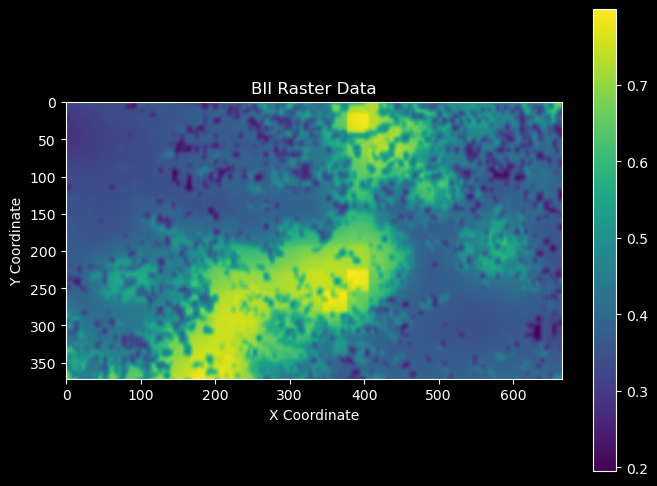

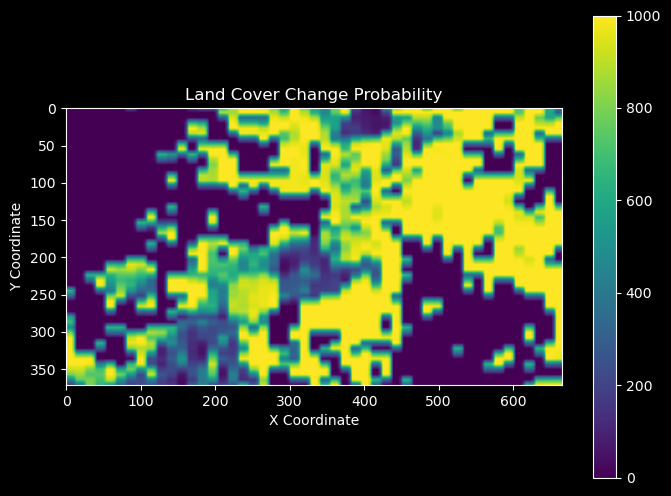

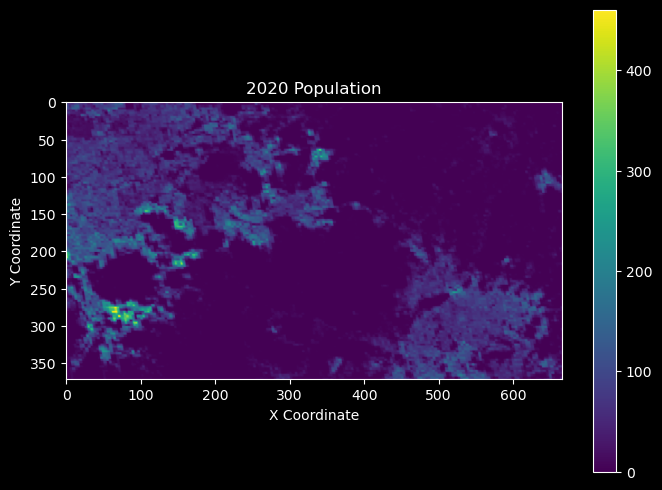

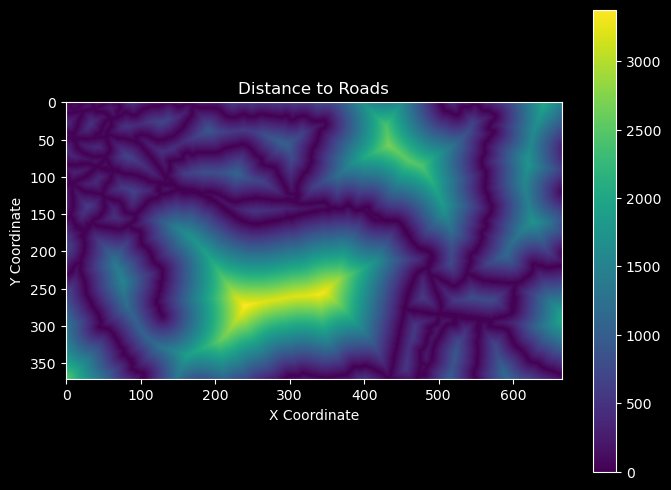

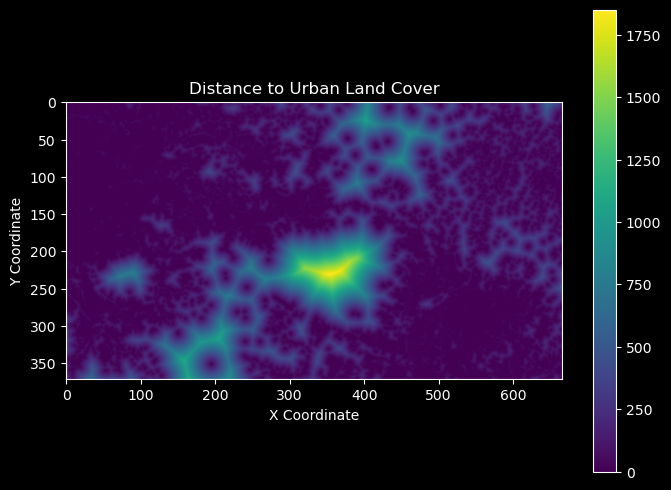

In [3]:
# List of tuples containing raster datasets and their titles
raster_data = [
    (bii, 'BII Raster Data'),
    (lc_vul_clark, 'Land Cover Change Probability'),
    (pop_2020, '2020 Population'),
    (dist_road, 'Distance to Roads'),
    (dist_urban, 'Distance to Urban Land Cover')
]

# Set a dark background style
plt.style.use('dark_background')

# Loop through each raster dataset and plot
for data, title in raster_data:
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap='viridis')
    plt.colorbar()
    plt.title(title, color='white')
    plt.xlabel('X Coordinate', color='white')
    plt.ylabel('Y Coordinate', color='white')
    plt.show()


In [4]:
# Ensure all rasters have the same shape
assert bii.shape == lc_vul_clark.shape == pop_2020.shape, "Rasters must be of the same size"

# Get coordinates
rows, cols = np.indices(bii.shape)
xs, ys = rasterio.transform.xy(bii_transform, rows, cols)

# Dictionary of arrays
arrays = {
    'x': np.array(xs),
    'y': np.array(ys),
    'bii_value': bii,
    'lc_vul_clark_value': lc_vul_clark,
    'pop_2020_value': pop_2020,
    'dist_road_value' : dist_road,
    'dist_urban_value' : dist_urban
}

# Flatten the arrays
flattened_arrays = {key: value.flatten() for key, value in arrays.items()}

# Create a DataFrame
df = pd.DataFrame(flattened_arrays)

# Drop NaN values if necessary
df.dropna(inplace=True)

# Save to CSV
# df.to_csv('/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/raster_data.csv', index=False)

df.head()

,x,y,bii_value,lc_vul_clark_value,pop_2020_value,dist_road_value,dist_urban_value
0,-84.071000,9.945727,0.319235,0.0,27.623455,42.884518,0.0
1,-84.070722,9.945727,0.319380,0.0,26.596148,55.026615,0.0
2,-84.070444,9.945727,0.319526,0.0,43.912666,70.259743,0.0
3,-84.070166,9.945727,0.319671,0.0,67.430809,71.825813,0.0
4,-84.069888,9.945727,0.320295,0.0,69.278877,71.825813,0.0


In [5]:
# Choose either Min-Max Scaling or Standardization based on your needs

# Option 1: Min-Max Scaling
min_max_scaler = MinMaxScaler()
# X = min_max_scaler.fit_transform(df[['bii_value', 'lc_vul_clark_value', 'pop_2020_value']])

# Standardization
standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(df[['bii_value', 'lc_vul_clark_value', 'pop_2020_value']])
X = standard_scaler.fit_transform(df[['bii_value', 'lc_vul_clark_value', 'dist_road_value']])


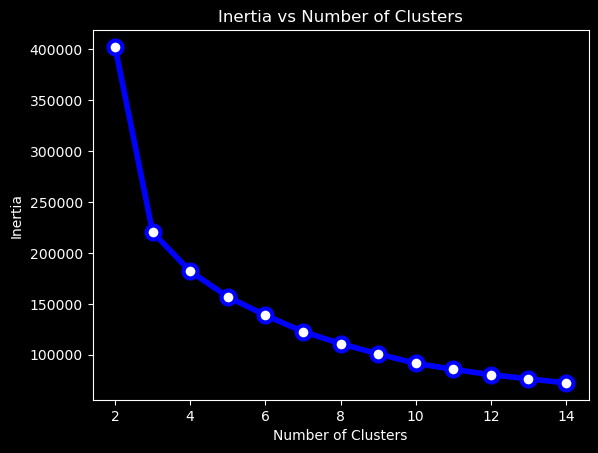

In [6]:
from sklearn.cluster import KMeans

# Number of clusters to try out
n_clusters = list(range(2, 15))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=600)
    kmeans.fit(X)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
# Set a dark background style for the plot
plt.style.use('dark_background')

# Plotting the data
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3, color='blue')

# Setting labels and title with light color for visibility
plt.title('Inertia vs Number of Clusters', color='white')
plt.xlabel('Number of Clusters', color='white')
plt.ylabel('Inertia', color='white')

# Display the plot
plt.show()


In [7]:
from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

4


In [8]:
# Initialize the Kmeans object
# Using the identified knee
kmeans = KMeans(n_clusters=(kn.knee), random_state=42, n_init=10)
# Using a manually-assigned knee
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Run the fit! This adds the ".labels_" attribute
kmeans.fit(X);

# Save the cluster labels
df["cluster"] = kmeans.labels_

In [9]:
# DBSCAN clustering
# dbscan = DBSCAN(eps=0.05, min_samples=4)  # Adjust 'eps' and 'min_samples' as needed
# df['cluster'] = dbscan.fit_predict(X)

# df now contains the original data and cluster labels
# Optionally, save the DataFrame
# df.to_csv('dbscan_clustered_data_with_spatial_info.csv', index=False)

In [10]:
df.head()

,x,y,bii_value,lc_vul_clark_value,pop_2020_value,dist_road_value,dist_urban_value,cluster
0,-84.071000,9.945727,0.319235,0.0,27.623455,42.884518,0.0,2
1,-84.070722,9.945727,0.319380,0.0,26.596148,55.026615,0.0,2
2,-84.070444,9.945727,0.319526,0.0,43.912666,70.259743,0.0,2
3,-84.070166,9.945727,0.319671,0.0,67.430809,71.825813,0.0,2
4,-84.069888,9.945727,0.320295,0.0,69.278877,71.825813,0.0,2


In [11]:
# Count the number of rows for each cluster and sort them to see which clusters have the greatest number of rows
cluster_counts = df['cluster'].value_counts().sort_values(ascending=False)

# Display the counts
print(cluster_counts)

2    101682
3     66361
1     45889
0     33820
Name: cluster, dtype: int64


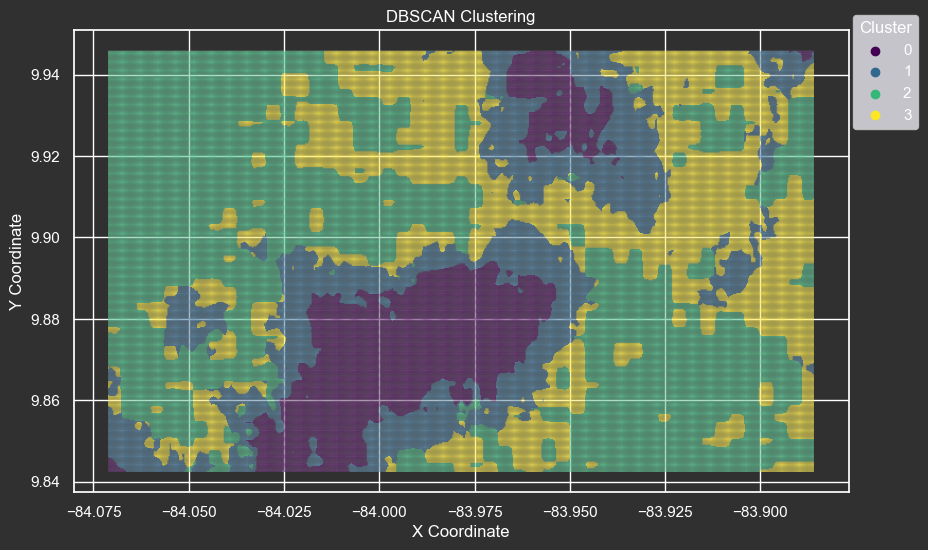

In [12]:
# Set the style of the visualization with a dark background
sns.set(style="darkgrid")

# Create a scatter plot with smaller points
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='x', y='y', hue='cluster', palette='viridis', data=df, s=0.5)

# Adding title and labels with a light color for visibility against the dark background
plt.title('DBSCAN Clustering', color='white')
plt.xlabel('X Coordinate', color='white')
plt.ylabel('Y Coordinate', color='white')

# Change the color of ticks and labels for visibility
plt.xticks(color='white')
plt.yticks(color='white')

# Modify legend for better visibility on dark background
legend = plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.1, 1.05), frameon=True)
plt.setp(legend.get_texts(), color='white')  # Set the legend text color
plt.setp(legend.get_title(), color='white')  # Set the legend title color

# Set the face and edge color of the figure to match the dark theme
plt.gcf().set_facecolor('#303030')
plt.gca().set_facecolor('#303030')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')

# Display the plot
plt.show()


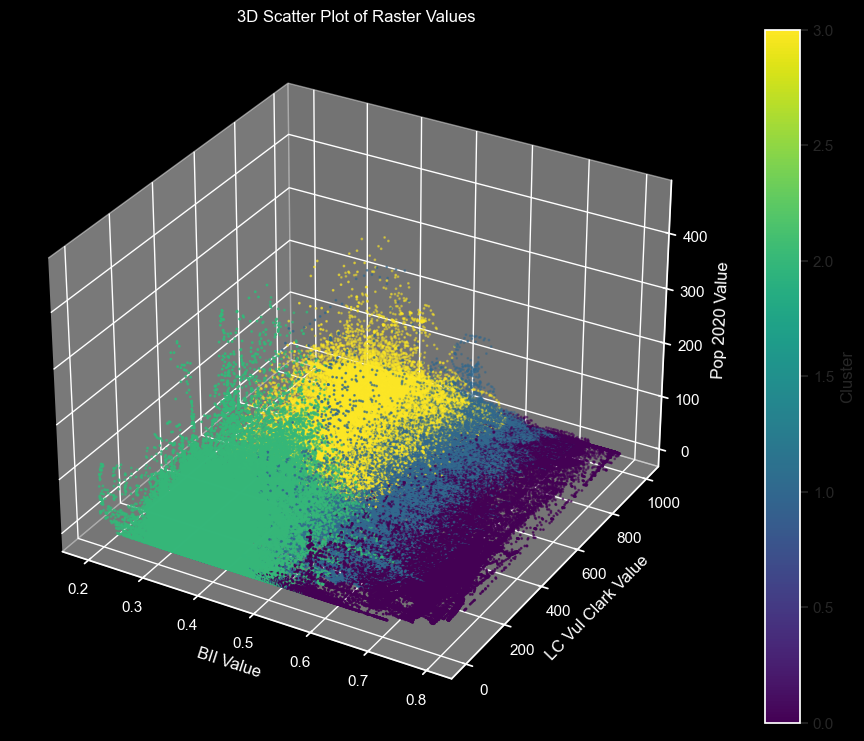

In [13]:
# Filter out data from cluster 0
# df = df[~df['cluster'].isin([0, -1])]

# Create a 3D scatter plot using matplotlib
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

# Define colormap
cmap = plt.get_cmap('viridis')

# Scatter plot
sc = ax.scatter(df['bii_value'], df['lc_vul_clark_value'], df['pop_2020_value'], c=df['cluster'], cmap=cmap, s=1)

# Color bar
plt.colorbar(sc, label='Cluster')

# Set dark background
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Titles and labels
ax.set_title("3D Scatter Plot of Raster Values", color='white')
ax.set_xlabel('BII Value', color='white')
ax.set_ylabel('LC Vul Clark Value', color='white')
ax.set_zlabel('Pop 2020 Value', color='white')

# Change the color of ticks and labels for visibility
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')

# Show the plot
plt.show()


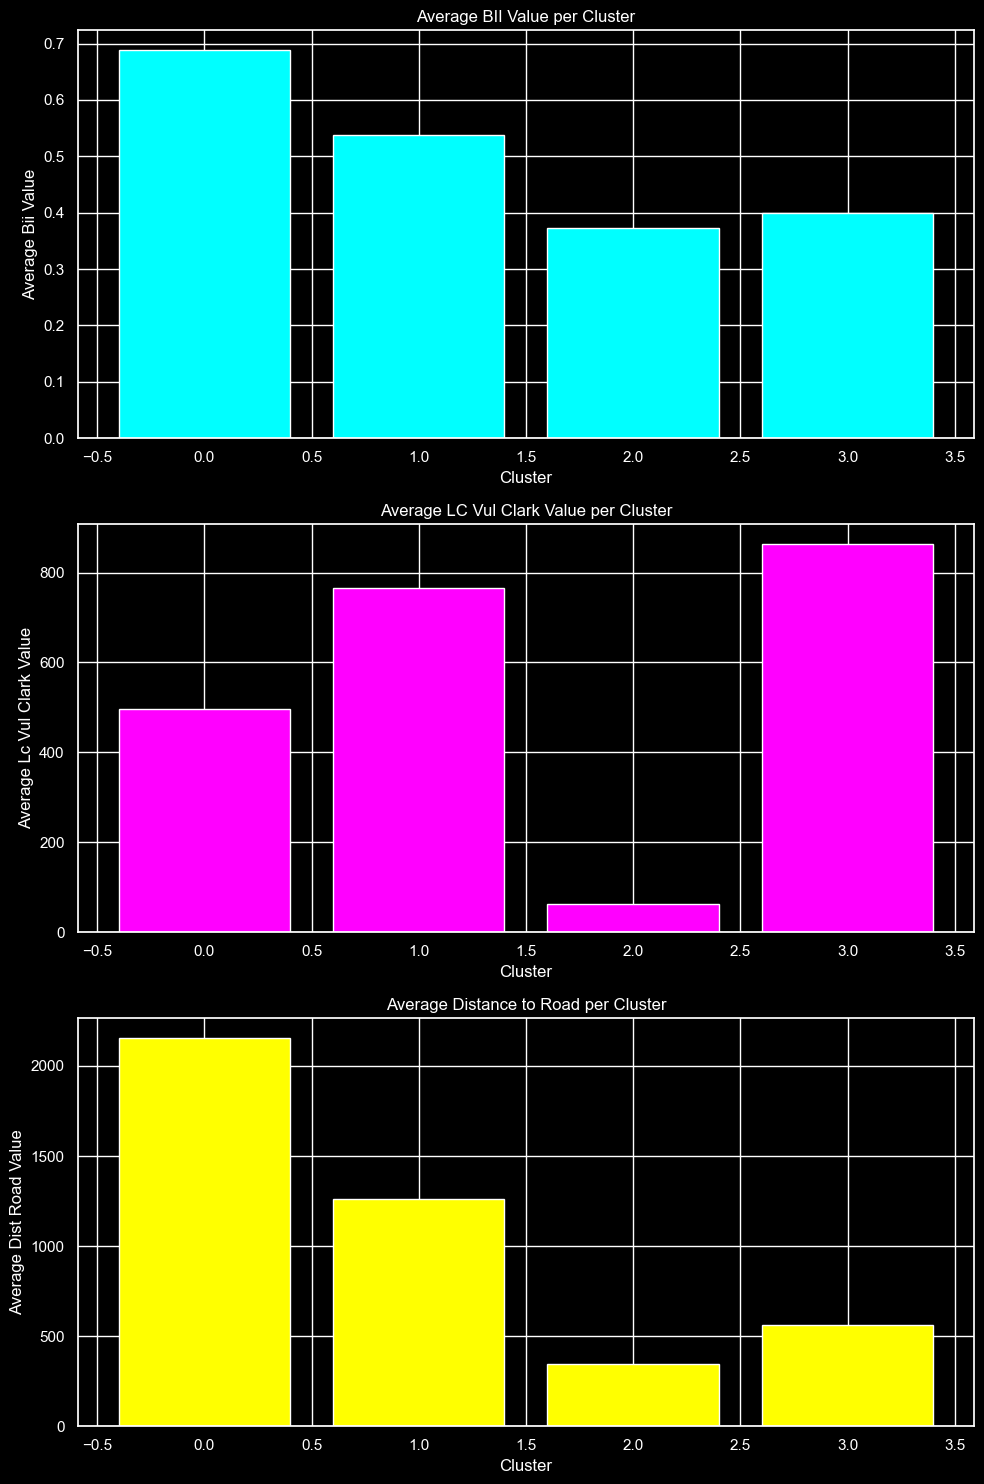

In [16]:
# Group by 'cluster' and calculate mean for each column
cluster_summary = df.groupby('cluster')[['bii_value', 'lc_vul_clark_value', 'dist_road_value']].mean()

# Set dark mode style
plt.style.use('dark_background')

# Plotting each column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Titles and colors for each plot
plot_titles = ['Average BII Value per Cluster', 'Average LC Vul Clark Value per Cluster', 'Average Distance to Road per Cluster']
colors = ['cyan', 'magenta', 'yellow']
columns = ['bii_value', 'lc_vul_clark_value', 'dist_road_value']

# Use a for loop to create each plot
for ax, title, color, column in zip(axes, plot_titles, colors, columns):
    ax.bar(cluster_summary.index, cluster_summary[column], color=color)
    ax.set_title(title, color='white')
    ax.set_xlabel('Cluster', color='white')
    ax.set_ylabel(f'Average {column.replace("_", " ").title()}', color='white')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [15]:
print(df.dtypes)

x                     float64
y                     float64
bii_value             float32
lc_vul_clark_value    float32
pop_2020_value        float32
dist_road_value       float32
dist_urban_value      float32
cluster                 int32
dtype: object
